In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/Revisit'

/content/drive/.shortcut-targets-by-id/1cPT7D9rHt29-x9ZGcn95v7SJvdL_brht/Revisit


In [4]:
import numpy as np
import zipfile, os, cv2
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model,Model
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib
import requests
import base64
import os
from pathlib import Path
from io import BytesIO
matplotlib.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['axes.grid'] = False

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Dataloader

In [ ]:
# IMG_SHAPE = (256, 256, 3)
archive = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Revisit/oulu/Train/square_oulu_png.zip', 'r')
image_paths = [k for k in list(archive.namelist()) if '.png' in k]
print('Train: Total =',len(image_paths), ', Spoof =',len([path for path in image_paths if 'spoof' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

archive = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Revisit/oulu/Dev/square_oulu_png.zip', 'r')
image_paths = [k for k in list(archive.namelist()) if '.png' in k]
print('Val: Total =',len(image_paths), ', Spoof =',len([path for path in image_paths if 'spoof' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

archive = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Revisit/oulu/Test/test.zip', 'r')
image_paths = [k for k in list(archive.namelist()) if '.png' in k]
print('Test: Total =',len(image_paths), ', Spoof =',len([path for path in image_paths if 'spoof' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

KeyboardInterrupt: ignored

In [5]:
def new_py_function(func, inp, Tout, name=None):
  def wrapped_func(*flat_inp):
    reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,expand_composites=True)
    out = func(*reconstructed_inp)
    return tf.nest.flatten(out, expand_composites=True)
  flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
  flat_out = tf.py_function(
      func=wrapped_func, 
      inp=tf.nest.flatten(inp, expand_composites=True),
      Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
      name=name)
  spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, 
                                   expand_composites=True)
  out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
  return out

def _dtype_to_tensor_spec(v):
  return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
  return v.dtype if isinstance(v, tf.TensorSpec) else v

In [6]:
class DataLoader:
  def __init__(self, dataset_path, batch_size=4, image_size=(256, 256), shuffle=True):
    self.archive = zipfile.ZipFile(dataset_path, 'r')
    self.images_paths = [k for k in list(self.archive.namelist()) if '.png' in k]
    self.length = len(self.images_paths)
    self.dim = image_size
    dataset = tf.data.Dataset.from_tensor_slices(self.images_paths).map(
            self.pad_map_fn, num_parallel_calls=3
          )
    if shuffle:
      dtaset = dataset.shuffle(buffer_size=100000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=3)
    # dataset = dataset.repeat()
    self.dataset = dataset.apply(tf.data.experimental.ignore_errors())  
                  
  def __len__(self):
        return self.length

  def load_tf_image(self, image_path):
    image_path = image_path.numpy().decode("utf-8")
    img_data = self.archive.read(image_path.strip())
    image = np.frombuffer(img_data, np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, self.dim)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.per_image_standardization(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # label - spoof = 0, real = 1
    if 'spoof' in image_path:
      label =  tf.constant([0])
      label_8 = tf.zeros_like(tf.random.uniform(shape=(8,8,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_4 = tf.zeros_like(tf.random.uniform(shape=(4,4,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_2 = tf.zeros_like(tf.random.uniform(shape=(2,2,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_1 = tf.zeros_like(tf.random.uniform(shape=(1,1,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
    if 'real' in image_path:
      label = tf.constant([1])
      label_8 = tf.ones_like(tf.random.uniform(shape=(8,8,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_4 = tf.ones_like(tf.random.uniform(shape=(4,4,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_2 = tf.ones_like(tf.random.uniform(shape=(2,2,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_1 = tf.ones_like(tf.random.uniform(shape=(1,1,1), minval=0, maxval=1, dtype=tf.dtypes.float32))

    return {'image': image, 'label': label, 'label_8': label_8, 'label_4': label_4, 'label_2': label_2, 'label_1': label_1}

  def pad_map_fn(self, img_path):
    return new_py_function(self.load_tf_image, inp=[img_path], Tout=({"image": tf.float32, "label": tf.int32, 'label_8': tf.float32, 'label_4': tf.float32, 'label_2': tf.float32, 'label_1': tf.float32}))

In [7]:
loader = DataLoader('/content/drive/MyDrive/Colab Notebooks/Revisit/oulu/Train/square_oulu_png.zip', batch_size=32)

In [ ]:
dataset = loader.dataset.take(2)
# list(dataset.as_numpy_iterator())
a = list(dataset.as_numpy_iterator())
for a in list(dataset.as_numpy_iterator()):
  print(a['image'].shape, a['label'].shape, a['label_8'].shape, a['label_4'].shape, a['label_2'].shape, a['label_1'].shape)

(32, 256, 256, 3) (32, 1) (32, 8, 8, 1) (32, 4, 4, 1) (32, 2, 2, 1) (32, 1, 1, 1)
(32, 256, 256, 3) (32, 1) (32, 8, 8, 1) (32, 4, 4, 1) (32, 2, 2, 1) (32, 1, 1, 1)


# Model

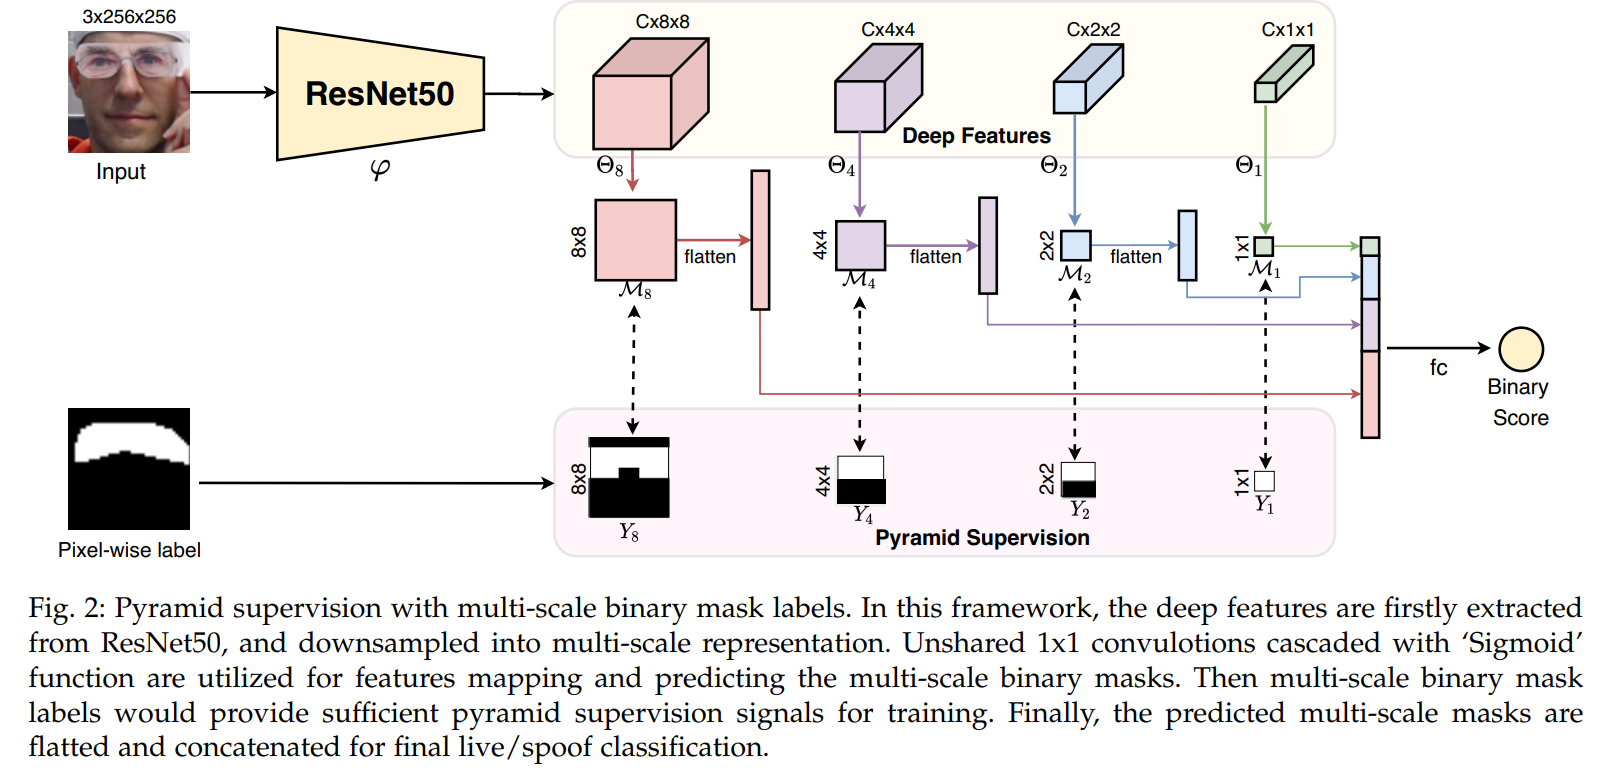

As shown in Fig., given a detected RGB face image
with size 3×256×256 (Channel×Height×Width) as input $X$,
the deep features $F_8$ with size C×8×8 could be extracted
via forwarding the backbone networks ’ (e.g., ResNet50).
Then average pooling operators with different kernel size
and strides are performed on F8 to generate multi-scale features $F_4$, $F_2$ and $F1$, respectively. Subsequently, respective
feature-to-mask mappings ($Θ_8$, $Θ_4$, $Θ_2$ and $Θ_1$) with 1x1
convolution are conducted on multi-scale features ($F_8$, $F_4$,
$F_2$ and $F_1$) to predict the corresponding binary masks ($M_8$,
$M_4$, $M_2$ and $M_1$), which are then concatenated for final
binary classification. The procedure of multi-scale binary
mask prediction could be formulated as:

$M_i = Sigmoid(\Theta_{i}(AvgPool_{i}(\varphi(X)))),i = {8,4,2,1}$

where the setting kernel & stride= 1,2,4,8 is utilized for
$AvgPool_8; AvgPool_4; AvgPool_2; AvgPool_1,$ respectively.
The $Sigmoid$ function guarantees the predicted masks
ranging from [0,1].

Loss function:

$L_{pyramid} = \sum_{i=8,4,2,1}^{} -(Y_{i}log(M_i)+ (1 − Y_i)log(1 − M_i))$

In [8]:
IMG_SHAPE = (256, 256, 3)

In [9]:
# testing the backbone
backbone = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = backbone(inputs)
# x = keras.layers.ZeroPadding2D(padding=(1, 1))(x)
outputs = tf.keras.layers.Conv2D(1280, 2, strides=(1, 1), padding="same", activation='relu', input_shape=IMG_SHAPE[1:])(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 1280)        6554880   
Total params: 8,812,864
Trainable params: 8,778,752
Non-trainable params: 34,112
_________________________________________________________________


In [10]:
class RevisitResNet50(tf.keras.Model):
  def __init__(self, name="revisit_resnet50", **kwargs):
    super(RevisitResNet50, self).__init__()
    self.backbone = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    # self.b1 = layers.ZeroPadding2D(padding=(1, 1))
    self.b2 = layers.Conv2D(1280, 2, strides=(1, 1), padding="same", activation='relu', input_shape=IMG_SHAPE[1:])
    # avg. pooling
    self.avgpool_8 = layers.AveragePooling2D(pool_size=(1,1), strides=1, padding='valid', data_format=None)
    self.avgpool_4= layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='valid', data_format=None)
    self.avgpool_2= layers.AveragePooling2D(pool_size=(4,4), strides=4, padding='valid', data_format=None)
    self.avgpool_1= layers.AveragePooling2D(pool_size=(8,8), strides=8, padding='valid', data_format=None)
    # 1x1 conv
    self.theta_8 = layers.Conv2D(1, (1,1), activation='sigmoid')
    self.theta_4 = layers.Conv2D(1, (1,1), activation='sigmoid')
    self.theta_2 = layers.Conv2D(1, (1,1), activation='sigmoid')
    self.theta_1 = layers.Conv2D(1, (1,1), activation='sigmoid')
    # dense layer
    self.fc = layers.Dense(1, activation='sigmoid')
    # loss
    self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  def call(self, input_img, label_8, label_4, label_2, label_1):
    F = self.backbone(input_img)
    # F = self.b1(F)
    F = self.b2(F)
    # M8
    x = self.avgpool_8(F)
    M8 = self.theta_8(x)
    # M4
    x = self.avgpool_4(F)
    M4 = self.theta_4(x)
    # M2
    x = self.avgpool_2(F)
    M2 = self.theta_2(x)
    # M1
    x = self.avgpool_1(F)
    M1 = self.theta_1(x)
    # concatenate and predict
    x = layers.Concatenate(axis=1)([layers.Flatten()(M8), layers.Flatten()(M4), layers.Flatten()(M2), layers.Flatten()(M1)])
    y_pred = self.fc(x)
    # pyramid loss
    pyramid_loss = tf.reduce_mean([self.loss_object(label_8, M8), self.loss_object(label_4, M4), self.loss_object(label_2, M2), self.loss_object(label_1, M1)])
    self.add_loss(pyramid_loss)

    return y_pred
  
  def build_model(self):
    x = layers.Input(shape=IMG_SHAPE)
    label_8 = layers.Input(shape=(8,8,1), dtype="float32")
    label_4 = layers.Input(shape=(4,4,1), dtype="float32")
    label_2 = layers.Input(shape=(2,2,1), dtype="float32")
    label_1 = layers.Input(shape=(1,1,1), dtype="float32")
    return Model(inputs=[x, label_8, label_4, label_2, label_1], outputs=self.call(x, label_8, label_4, label_2, label_1))


revisit_model = RevisitResNet50()
test_model = revisit_model.build_model()
test_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 8, 8, 1280)   2257984     input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 1280)   6554880     mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 8, 8, 1280)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

# Training and evaluation of Resnet with pyramid supervision
**Link:** 

*   https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example
*   https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough



In [11]:
def calculate_apcer(y_true, y_pred):
    true_spoof = 0  #### Spoof being 1
    false_real = 0  #### real being 0
    for i in range(len(y_true)):
        target = y_true[i]
        pred = y_pred[i]
        if target:
            true_spoof += 1
            if not pred:
                false_real += 1
    return false_real / true_spoof if true_spoof else 0

In [12]:
def calculate_bpcer(y_true, y_pred):
    true_real = 0  #### Spoof being 1
    false_spoof = 0  #### real being 0
    for i in range(len(y_true)):   
        target = y_true[i]
        pred = y_pred[i]
        if not target:
            true_real += 1
            if pred:
                false_spoof += 1
    return false_spoof / true_real if true_real else 0

In [13]:
train_loader = DataLoader('/content/drive/MyDrive/Colab Notebooks/Revisit/oulu/Train/square_oulu_png.zip', batch_size=32, shuffle=True)
val_loader =  DataLoader('/content/drive/MyDrive/Colab Notebooks/Revisit/oulu/Dev/square_oulu_png.zip', batch_size=32, shuffle=False)

In [14]:
len(train_loader.dataset)

7518

In [15]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=5e-5)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, decay=5e-5)
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_metric = tf.keras.metrics.Mean()

In [16]:
revisit_model.load_weights('/content/drive/MyDrive/Colab Notebooks/Revisit/checkpoints/mobilenetv2/cp.ckpt')

In [ ]:
epochs = 80
start = datetime.now()
for epoch in range(epochs):
  print("Start of epoch %d" % (epoch+1,))

  # Iterate over the batches of the dataset
  for step, batch_train in enumerate(train_loader.dataset):
    # print(batch_train['image'].shape, batch_train['label'].shape, batch_train['label_8'].shape, batch_train['label_4'].shape, batch_train['label_2'].shape, batch_train['label_1'].shape)
    
    with tf.GradientTape() as tape:
        pred = revisit_model(batch_train['image'], batch_train['label_8'], batch_train['label_4'], batch_train['label_2'], batch_train['label_1'], training=True)
        # compute bcse loss
        loss = bce_loss_fn(batch_train['label'], pred)
        loss += sum(revisit_model.losses)  # add pyramid loss

    grads = tape.gradient(loss, revisit_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, revisit_model.trainable_weights))

    loss_metric(loss)

    if (step+1) % 1000 == 0:
      diff_time = datetime.now()-start
      days, seconds = diff_time.days, diff_time.seconds
      hours = days * 24 + seconds // 3600
      minutes = (seconds % 3600) // 60
      seconds = seconds % 60
      print("step %d: mean loss = %.6f, time = %d:%d:%d" % (step+1, loss_metric.result(), hours, minutes, seconds))
      revisit_model.save_weights('/content/drive/MyDrive/Colab Notebooks/Revisit/checkpoints/mobilenetv2/cp.ckpt')

revisit_model.save_weights('/content/drive/MyDrive/Colab Notebooks/Revisit/checkpoints/mobilenetv2/cp.ckpt')

Start of epoch 1
